## Multi-Horizon Correlation Maps (14d / 30d / 60d / 90d)

**Dataset Context**  
This analysis is based on a consolidated research file containing **311 actively traded cryptocurrencies**, each mapped to standardized sector categories and blockchain family groupings.  
The dataset merges daily OHLCV histories with enriched metadata, enabling correlation patterns to be interpreted both numerically and within broader thematic and ecosystem contexts.  
All symbols meet minimum data completeness standards, ensuring that the multi-horizon results reflect robust, comparable relationships across the full crypto universe studied.

**Objective**  
Quantify and visualize the co-movement between individual assets over multiple lookback horizons.  
By examining correlations at different time scales, we can identify both stable long-term relationships and short-term shifts in alignment or divergence.

**Analytical Scope**
- **14-day horizon:** Captures very recent co-movement patterns, often influenced by short-term events or market sentiment shifts.
- **30-day horizon:** Represents approximately one month of trading, smoothing some noise while retaining tactical sensitivity.
- **60-day horizon:** Serves as a bridge between short-term fluctuations and structural relationships.
- **90-day horizon:** Highlights more persistent patterns and medium-term structural co-movement.

**Deliverables**
1. **Clustered correlation heatmaps** for each horizon to highlight groupings and relationship strength.
2. **Pair tables** that list the strongest positive and negative correlations for each horizon, alongside sector and family metadata.
3. A standardized data structure (`corr_mats` and `corr_mats_clust`) for use in later network graphs, portfolio design studies, and diversification analysis.

**Methodology Notes**
- All correlations are computed from close-to-close daily returns.
- Where data gaps exist within the lookback window, missing values are treated neutrally (filled with zero returns) unless full-window completeness is explicitly required.
- Cluster order is determined by hierarchical clustering on a correlation-derived distance metric, improving readability of blocks in the heatmap.
- Metadata from the master asset file is merged into results so that each symbol is tied to its consolidated categories and family assignments.

**Why This Matters**  
Multi-horizon correlation analysis provides a statistical map of how assets behave in relation to one another over time.  
These relationships are essential for later sections where relative value ideas, diversification strategies, and thematic basket construction are explored.

### 3.3.1 — Prep: Load research parquet, build multi‑horizon correlation maps (14d/30d/60d/90d)

Notes
- Uses `research_ohlcv_1d.parquet` as the canonical time‑series dataframe (`df`).
- Computes daily returns `r1` if missing.
- Builds wide return panel and correlation matrices for each horizon.
- Produces clustered versions (`corr_mats_clust`) for plotting.

In [37]:
# --- 3.3.1.A Prep: load parquet, build multi-horizon correlation maps ---
import os
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

# Paths
parquet_path = r"C:\Users\User\PycharmProjects\LiveTradingBots\research_ohlcv_1d.parquet"
meta_csv     = r"C:\Users\User\PycharmProjects\LiveTradingBots\asset_metadata_master.csv"

# Load full research parquet as df (time series)
df = pd.read_parquet(parquet_path)
df["date"] = pd.to_datetime(df["date"], utc=False)
df = df.sort_values(["symbol","date"]).reset_index(drop=True)

# Ensure daily returns
if "r1" not in df.columns:
    df["r1"] = df.groupby("symbol", group_keys=False)["close"].apply(
        lambda s: s.pct_change(fill_method=None)
    )

# Latest snapshot (one row per symbol for metadata joins, etc.)
last_idx = df.groupby("symbol")["date"].idxmax()
latest_snapshot = df.loc[last_idx].copy().sort_values("symbol").reset_index(drop=True)

# Attach metadata (consolidated categories / families) if not already present
need_meta = ["consolidated_categories_list", "family_list"]
missing = [c for c in need_meta if c not in latest_snapshot.columns]
if missing:
    # try from df (last known per symbol)
    avail = [c for c in missing if c in df.columns]
    meta_add = pd.DataFrame({"symbol": []})
    if avail:
        meta_add = (
            df.sort_values("date")
              .groupby("symbol")[avail]
              .last()
              .reset_index()
        )
    # fall back to metadata CSV if needed
    still_missing = [c for c in need_meta if c not in meta_add.columns]
    if still_missing:
        meta_raw = pd.read_csv(meta_csv, encoding="ISO-8859-1")
        if "consolidated_categories_list" not in meta_raw.columns and "consolidated_categories" in meta_raw.columns:
            meta_raw["consolidated_categories_list"] = (
                meta_raw["consolidated_categories"].fillna("").astype(str)
                .str.split(",").apply(lambda xs: [s.strip() for s in xs if s.strip()])
            )
        if "family_list" not in meta_raw.columns and "crypto_family" in meta_raw.columns:
            meta_raw["family_list"] = (
                meta_raw["crypto_family"].fillna("").astype(str)
                .str.split(",").apply(lambda xs: [s.strip() for s in xs if s.strip()])
            )
        meta_raw = meta_raw[["symbol"] + still_missing]
        meta_add = meta_add.merge(meta_raw, on="symbol", how="outer") if not meta_add.empty else meta_raw

    latest_snapshot = latest_snapshot.merge(meta_add, on="symbol", how="left")

# Ensure market_cap on snapshot (for later filtering/plots)
if "market_cap" not in latest_snapshot.columns:
    if "market_cap" in df.columns:
        mc_add = (
            df.sort_values("date")
              .groupby("symbol")["market_cap"]
              .last()
              .reset_index()
        )
        latest_snapshot = latest_snapshot.merge(mc_add, on="symbol", how="left")
    else:
        latest_snapshot["market_cap"] = np.nan

# Wide daily returns panel
ret = df.pivot(index="date", columns="symbol", values="r1").sort_index()

# Correlation matrices for each horizon (tolerant of NaNs by filling 0 in-window)
HORIZONS = {"14d": 14, "30d": 30, "60d": 60, "90d": 90}
REQUIRE_FULL_WINDOW = False  # set True to drop symbols lacking full window

def corr_matrix(ret_wide: pd.DataFrame, w: int, require_full: bool) -> pd.DataFrame:
    tail = ret_wide.dropna(how="all").tail(w)
    if require_full:
        tail = tail.dropna(axis=1, how="any")
    else:
        tail = tail.fillna(0.0)
    return tail.corr()

def cluster_order(C: pd.DataFrame):
    if C.shape[0] < 3:
        return C.index
    # correlation -> distance
    d = np.sqrt(np.clip((1 - C.values)/2, 0, 1))
    Z = linkage(squareform(d, checks=False), method="average")
    idx = leaves_list(Z)
    return C.index[idx]

corr_mats = {}
corr_mats_clust = {}
for label, w in HORIZONS.items():
    C = corr_matrix(ret, w, REQUIRE_FULL_WINDOW)
    if C.empty:
        print(f"{label}: no usable symbols in {w}d window.")
        corr_mats[label] = C
        corr_mats_clust[label] = C
        continue
    order = cluster_order(C)
    corr_mats[label] = C
    corr_mats_clust[label] = C.loc[order, order]
    print(f"{label}: corr matrix built with {C.shape[0]} symbols.")

# Compact meta map (for tables/hover later)
meta_map = latest_snapshot.set_index("symbol")[["consolidated_categories_list","family_list","market_cap"]].to_dict("index")
print("✅ Correlation prep complete (df, latest_snapshot, corr_mats, corr_mats_clust ready).")

14d: corr matrix built with 311 symbols.
30d: corr matrix built with 311 symbols.
60d: corr matrix built with 311 symbols.
90d: corr matrix built with 311 symbols.
✅ Correlation prep complete (df, latest_snapshot, corr_mats, corr_mats_clust ready).


## 3.3.2 — Averaged Correlation, Clustermap & Ranked Pairs

**Objective**  
Aggregate correlations from multiple horizons (14d, 30d, 60d, 90d) into a single average value for each asset pair.  
This provides a consolidated measure of relationship strength that incorporates both short-term and medium-term behavior.

**Why This Matters**  
Averaging across horizons helps reduce the influence of outlier periods and offers a more stable view of how two assets tend to move together or apart.  
This can reveal:
- **Highly positively correlated pairs** → potential sector proxies or basket components.
- **Highly negatively correlated pairs** → potential hedging or relative value opportunities.
- **Uncorrelated pairs** → diversification candidates.

**Outputs**
1. **Cluster map** of the 200 strongest absolute correlations (positive and negative combined).
2. **Excel file** with three sheets:
   - `TopPositive`: highest average correlations.
   - `TopNegative`: lowest (most negative) average correlations.
   - `TopUncorrelated`: pairs with correlations closest to zero (weak/no relationship).
3. **Printed preview table**: top 200 positive pairs.

**Methodology Notes**
- The average correlation is computed across all available horizons.
- All correlations are computed on close-to-close daily returns.
- Metadata (family and sector) are included for both assets in each pair.
- The “TopUncorrelated” sheet sorts by absolute correlation ascending; these are the most neutral historical relationships in the dataset.

#### Important Note on Missing Correlations (Zero ≠ Neutral)

In earlier drafts, some correlation matrices were built by **filling missing returns with `0.0` inside the window**. That had the side‑effect of producing **`0` correlations where the data were actually missing**, which can bias rankings (e.g., pushing true unknown pairs into the “uncorrelated” bucket).

**Fix implemented below**
- We **recompute** all 14d/30d/60d/90d correlation matrices using **pairwise complete observations** (no zero‑fill in‑window).  
- Any pair without sufficient overlapping data is left as **`NaN`**, and **excluded** from averages and rankings.
- The averaged correlation per pair uses a **NaN‑skipping mean** across horizons, and we require a **minimum number of horizons** before the pair is eligible for ranking.

You’ll see a new `horizons_available` column indicating how many horizons (0–4) contributed to each pair’s average.

In [38]:
# === 3.3.2 — Averaged Correlations, Ranked Pair Tables & Export (NaN-safe) ===
import os
import numpy as np
import pandas as pd
from itertools import combinations

# ==================
# Parameters
# ==================
PROJECT_ROOT = r"C:\Users\User\PycharmProjects\LiveTradingBots"
CH3_DIR = os.path.join(PROJECT_ROOT, "Cryptocurrency Analysis Journal", "Chapter_3_MacroAnalysis_1d")
os.makedirs(CH3_DIR, exist_ok=True)
OUT_XLSX = os.path.join(CH3_DIR, "pairs_correlation_master.xlsx")

HORIZONS = {"corr_14d": 14, "corr_30d": 30, "corr_60d": 60, "corr_90d": 90}
TOPK_PRINT = 200
MIN_HORIZONS_FOR_RANK = 1   # require at least this many horizons to compute corr_avg

parquet_path = r"C:\Users\User\PycharmProjects\LiveTradingBots\research_ohlcv_1d.parquet"
meta_csv     = r"C:\Users\User\PycharmProjects\LiveTradingBots\asset_metadata_master.csv"

# ==================
# Load canonical TS and returns
# ==================
df = pd.read_parquet(parquet_path)
df["date"] = pd.to_datetime(df["date"], utc=False)
df = df.sort_values(["symbol","date"]).reset_index(drop=True)

if "r1" not in df.columns:
    df["r1"] = df.groupby("symbol", group_keys=False)["close"].apply(
        lambda s: s.pct_change(fill_method=None)
    )

# Latest snapshot for metadata map (one row per symbol)
last_idx = df.groupby("symbol")["date"].idxmax()
snap = df.loc[last_idx].copy()

# Ensure metadata columns on snapshot; fallback to metadata CSV if needed
for c in ["consolidated_categories_list","family_list","market_cap"]:
    if c not in snap.columns:
        snap[c] = np.nan

if any(c not in snap.columns or snap[c].isna().all() for c in ["consolidated_categories_list","family_list"]):
    meta = pd.read_csv(meta_csv, encoding="ISO-8859-1")
    if "consolidated_categories_list" not in meta.columns and "consolidated_categories" in meta.columns:
        meta["consolidated_categories_list"] = (
            meta["consolidated_categories"].fillna("").astype(str)
            .str.split(",").apply(lambda xs: [s.strip() for s in xs if s.strip()])
        )
    if "family_list" not in meta.columns and "crypto_family" in meta.columns:
        meta["family_list"] = (
            meta["crypto_family"].fillna("").astype(str)
            .str.split(",").apply(lambda xs: [s.strip() for s in xs if s.strip()])
        )
    snap = snap.drop(columns=[c for c in ["consolidated_categories_list","family_list"] if c in snap.columns], errors="ignore")
    snap = snap.merge(meta[["symbol","consolidated_categories_list","family_list"]], on="symbol", how="left")

# Dedupe for meta_map (unique symbol index)
snap_fix = snap.sort_values(["symbol","date"]).drop_duplicates("symbol", keep="last").copy()

def pretty_list(x):
    if isinstance(x, list):
        return ", ".join(map(str, x))
    if isinstance(x, str):
        s = x.strip()
        if s.startswith("[") and s.endswith("]"):
            import ast
            try:
                L = ast.literal_eval(s)
                if isinstance(L, list):
                    return ", ".join(map(str, L))
            except Exception:
                pass
        return s
    return "" if (x is None or (isinstance(x, float) and np.isnan(x))) else str(x)

meta_map = snap_fix.set_index("symbol")[["consolidated_categories_list","family_list","market_cap"]].to_dict("index")

# ==================
# Build pairwise-complete correlation matrices (NO zero fill)
# ==================
ret = df.pivot(index="date", columns="symbol", values="r1").sort_index()

def corr_matrix_pairwise(ret_wide: pd.DataFrame, w: int) -> pd.DataFrame:
    tail = ret_wide.dropna(how="all").tail(w)
    # No fill; pandas .corr uses pairwise complete observations by default
    return tail.corr()

corr_mats_nofill = {lbl: corr_matrix_pairwise(ret, w) for lbl, w in HORIZONS.items()}

# ==================
# Build merged pairs table across horizons
# ==================
def pairs_from_matrix(C: pd.DataFrame, label_for_col: str) -> pd.DataFrame:
    if C is None or C.empty:
        return pd.DataFrame(columns=["sym_a","sym_b",label_for_col])
    syms = C.index.tolist()
    rows = []
    for i in range(len(syms)):
        for j in range(i+1, len(syms)):
            v = C.iat[i, j]
            rows.append((syms[i], syms[j], v if np.isfinite(v) else np.nan))
    return pd.DataFrame(rows, columns=["sym_a","sym_b",label_for_col])

# start with first horizon then outer-merge the rest
hlabels = list(HORIZONS.keys())
pairs_all = pairs_from_matrix(corr_mats_nofill[hlabels[0]], hlabels[0])
for lbl in hlabels[1:]:
    pairs_all = pairs_all.merge(
        pairs_from_matrix(corr_mats_nofill[lbl], lbl),
        on=["sym_a","sym_b"], how="outer"
    )

# Average across horizons with NaN-skipping mean
pairs_all["horizons_available"] = pairs_all[hlabels].notna().sum(axis=1)
pairs_all["corr_avg"] = pairs_all[hlabels].mean(axis=1, skipna=True)

# ==================
# Add metadata columns (family / sectors / market cap)
# ==================
for side in ["a","b"]:
    pairs_all[f"{side}_family"]  = pairs_all[f"sym_{side}"].apply(lambda s: pretty_list((meta_map.get(s) or {}).get("family_list")))
    pairs_all[f"{side}_sectors"] = pairs_all[f"sym_{side}"].apply(lambda s: pretty_list((meta_map.get(s) or {}).get("consolidated_categories_list")))
    pairs_all[f"{side}_mcap"]    = pairs_all[f"sym_{side}"].apply(lambda s: (meta_map.get(s) or {}).get("market_cap"))

# ==================
# Rank: Positive / Negative / Uncorrelated (filter by MIN_HORIZONS_FOR_RANK)
# ==================
eligible = pairs_all[pairs_all["horizons_available"] >= MIN_HORIZONS_FOR_RANK].copy()

pairs_pos = eligible.sort_values("corr_avg", ascending=False).reset_index(drop=True)
pairs_neg = eligible.sort_values("corr_avg", ascending=True).reset_index(drop=True)

# For uncorrelated, sort by |corr_avg| ascending; use label-based .loc to avoid iloc issues
uncorr_index = eligible["corr_avg"].abs().sort_values(kind="mergesort").index
pairs_uncorr = eligible.loc[uncorr_index].reset_index(drop=True)

pairs_pos["rank_pos"] = np.arange(1, len(pairs_pos) + 1)
pairs_neg["rank_neg"] = np.arange(1, len(pairs_neg) + 1)
pairs_uncorr["rank_uncorr"] = np.arange(1, len(pairs_uncorr) + 1)

# ==================
# Save to Excel (3 sheets)
# ==================
with pd.ExcelWriter(OUT_XLSX) as writer:
    pairs_pos.to_excel(writer, sheet_name="TopPositive", index=False)
    pairs_neg.to_excel(writer, sheet_name="TopNegative", index=False)
    pairs_uncorr.to_excel(writer, sheet_name="TopUncorrelated", index=False)

print(f"✅ Saved ranked pairs (positive / negative / uncorrelated) → {OUT_XLSX}")

✅ Saved ranked pairs (positive / negative / uncorrelated) → C:\Users\User\PycharmProjects\LiveTradingBots\Cryptocurrency Analysis Journal\Chapter_3_MacroAnalysis_1d\pairs_correlation_master.xlsx


### Top Positive Correlations
Highest **average** correlations across 14d/30d/60d/90d (using pairwise mean over available windows).  
These are potential proxy/basket candidates; be mindful of redundancy.


In [39]:
import pandas as pd
import numpy as np

# --- knobs ---
TOP_POS = 10   # how many strongest positive pairs to list

# columns that *might* exist
HORIZ_COLS = [c for c in ["corr_14d","corr_30d","corr_60d","corr_90d"] if c in pairs_all.columns]
if not HORIZ_COLS:
    raise ValueError("pairs_all has no corr_* columns (e.g., corr_14d). Rebuild the pairs table first.")

# compute average correlation over available horizons (row-wise mean, skip NaN)
pairs_all = pairs_all.copy()
pairs_all["corr_avg"] = pairs_all[HORIZ_COLS].mean(axis=1, skipna=True)

pairs_pos = pairs_all.sort_values("corr_avg", ascending=False).head(TOP_POS).copy()
pairs_pos["sign"] = "Positive"

fmt = {"corr_avg":"{:.2f}", "a_mcap":"{:.3e}", "b_mcap":"{:.3e}"}
cols = ["sym_a","a_family","a_sectors","a_mcap",
        "sym_b","b_family","b_sectors","b_mcap",
        "corr_avg","sign"]

display(pairs_pos[cols].style.format(fmt).hide(axis="index")
        .set_caption(f"Top {TOP_POS} Positive Average Correlations"))

sym_a,a_family,a_sectors,a_mcap,sym_b,b_family,b_sectors,b_mcap,corr_avg,sign
MATIC,"Multi Chain, Ethereum, Polygon",Layer 2 / Scaling,2.131e+09,POL,Ethereum,Layer 2 / Scaling,1.973e+09,1.00,Positive
CBETH,Ethereum,DeFi,5.551e+08,ETH,Ethereum,DeFi,4.200e+11,1.00,Positive
FET,Ethereum,"DeFi, AI & Big Data",1.998e+09,JITOSOL,Ethereum,DeFi,2.850e+09,1.00,Positive
AUDIO,Ethereum,Other / Specialized,8.521e+07,JITOSOL,Ethereum,DeFi,2.850e+09,1.00,Positive
JITOSOL,Ethereum,DeFi,2.850e+09,MINA,Independent,"Layer 1 Blockchains, Privacy & Security",2.483e+08,1.00,Positive
JITOSOL,Ethereum,DeFi,2.850e+09,TIA,Celestia,Infrastructure & Data,1.318e+09,0.99,Positive
MKR,Ethereum,DeFi,9.504e+08,SKY,Solana,"DeFi, Stablecoins",1.835e+09,0.99,Positive
ZETA,Solana,DeFi,1.583e+07,ZETACHAIN,Independent,Layer 2 / Scaling,1.874e+08,0.99,Positive
ARKM,Ethereum,Infrastructure & Data,2.387e+08,JITOSOL,Ethereum,DeFi,2.850e+09,0.99,Positive
JITOSOL,Ethereum,DeFi,2.850e+09,TNSR,Solana,NFTs & Digital Collectibles,4.473e+07,0.99,Positive


### Top Negative Correlations
Lowest (most negative) **average** correlations across 14d/30d/60d/90d.  
Useful for hedge or long/short spread candidates.

In [40]:
TOP_NEG = 10   # how many strongest negative pairs to list

pairs_neg = pairs_all.sort_values("corr_avg", ascending=True).head(TOP_NEG).copy()
pairs_neg["sign"] = "Negative"

display(pairs_neg[cols].style.format(fmt).hide(axis="index")
        .set_caption(f"Top {TOP_NEG} Negative Average Correlations"))

sym_a,a_family,a_sectors,a_mcap,sym_b,b_family,b_sectors,b_mcap,corr_avg,sign
FIS,Substrate,DeFi,1.863e+07,MPLX,Solana,"NFTs & Digital Collectibles, Infrastructure & Data",1.473e+08,-0.80,Negative
A8,Independent,Gaming & Metaverse,3.708e+07,MPLX,Solana,"NFTs & Digital Collectibles, Infrastructure & Data",1.473e+08,-0.78,Negative
JITOSOL,Ethereum,DeFi,2.850e+09,KARRAT,Independent,"Gaming & Metaverse, Infrastructure & Data",3.835e+07,-0.67,Negative
ELA,Independent,Privacy & Security,3.170e+07,MPLX,Solana,"NFTs & Digital Collectibles, Infrastructure & Data",1.473e+08,-0.67,Negative
AURORA,NEAR Protocol,Other / Specialized,4.833e+07,MPLX,Solana,"NFTs & Digital Collectibles, Infrastructure & Data",1.473e+08,-0.67,Negative
HOPR,Ethereum,Privacy & Security,3.766e+07,MPLX,Solana,"NFTs & Digital Collectibles, Infrastructure & Data",1.473e+08,-0.62,Negative
EDGE,Ethereum,Infrastructure & Data,3.179e+07,MPLX,Solana,"NFTs & Digital Collectibles, Infrastructure & Data",1.473e+08,-0.60,Negative
FLR,Flare,Infrastructure & Data,1.711e+09,MPLX,Solana,"NFTs & Digital Collectibles, Infrastructure & Data",1.473e+08,-0.59,Negative
DRIFT,Solana,DeFi,1.900e+08,USDS,Independent,Stablecoins,7.711e+09,-0.59,Negative
CRV,Ethereum,DeFi,1.388e+09,MPLX,Solana,"NFTs & Digital Collectibles, Infrastructure & Data",1.473e+08,-0.58,Negative


### Top Uncorrelated Pairs
Pairs with **average correlation closest to zero** across 14d/30d/60d/90d (pairwise‑complete; missing horizons ignored).  
These represent **historically neutral** co‑movement and can be useful as diversification references.

*Notes:*  
- We require a minimum number of horizons to avoid spurious “uncorrelated” flags due to missing data.  
- The table shows both members’ **family** and **consolidated sectors**, plus the count of horizons used.


In [41]:
# --- Top Uncorrelated Pairs (closest to zero average correlation) ---
import numpy as np
import pandas as pd

TOP_UNCORR = 10          # how many near-zero pairs to list
MIN_HORIZONS_FOR_RANK = 2  # must match what you used upstream
HORIZON_COLS = ["corr_14d","corr_30d","corr_60d","corr_90d"]

# Ensure needed columns exist
need_cols = set(["sym_a","sym_b","corr_avg","horizons_available"]) | set(HORIZON_COLS) | {
    "a_family","a_sectors","a_mcap","b_family","b_sectors","b_mcap"
}
missing = [c for c in need_cols if c not in pairs_all.columns]
if missing:
    raise ValueError(f"pairs_all is missing required columns: {missing}")

# Eligible subset (enforce min horizons)
eligible_unc = pairs_all[pairs_all["horizons_available"] >= MIN_HORIZONS_FOR_RANK].copy()

# Sort by |corr_avg| ascending -> closest to zero first
pairs_uncorr = eligible_unc.loc[
    eligible_unc["corr_avg"].abs().sort_values(kind="mergesort").index
].head(TOP_UNCORR).copy()

pairs_uncorr["sign"] = np.where(pairs_uncorr["corr_avg"] >= 0, "Positive ~0", "Negative ~0")

# Columns and formatting
cols = [
    "sym_a","a_family","a_sectors","a_mcap",
    "sym_b","b_family","b_sectors","b_mcap",
    "corr_avg",
]
fmt = {
    "a_mcap":"{:.3e}",
    "b_mcap":"{:.3e}",
    "corr_avg":"{:.7f}",
    "horizons_available":"{:d}"
}

display(
    pairs_uncorr[cols]
      .style.format(fmt)
      .hide(axis="index")
      .set_caption(f"Top {TOP_UNCORR} Uncorrelated Pairs — Average Correlation ≈ 0 (min horizons = {MIN_HORIZONS_FOR_RANK})")
)

sym_a,a_family,a_sectors,a_mcap,sym_b,b_family,b_sectors,b_mcap,corr_avg
FOX,Ethereum,DeFi,1.830e+07,WCFG,"Multi Chain, Ethereum, Polkadot",Other / Specialized,6.461e+07,0.0000418
ATOM,Solana,DeFi,2.225e+09,PAX,Ethereum,Stablecoins,6.991e+07,-0.0000645
APT,Independent,Other / Specialized,3.035e+09,LA,Ethereum,Other / Specialized,6.944e+07,0.0000857
KARRAT,Independent,"Gaming & Metaverse, Infrastructure & Data",3.835e+07,SD,Multi-chain,DeFi,4.766e+07,-0.0000946
AXS,"Ethereum, Ronin","NFTs & Digital Collectibles, Gaming & Metaverse",4.374e+08,TUSD_USD,,,nan,0.0001078
IDEX,Ethereum,DeFi,1.948e+07,XYO,Ethereum,Other / Specialized,1.568e+08,0.0001267
AXL,Cosmos,Layer 2 / Scaling,3.671e+08,INV,Ethereum,DeFi,3.085e+07,0.0001447
MDT,Ethereum,Infrastructure & Data,1.709e+07,PROMPT,Ethereum,"Infrastructure & Data, AI & Big Data",2.823e+07,-0.0001448
KNC,Ethereum,DeFi,7.654e+07,TRX_USD,,,nan,-0.0001497
AUCTION,Ethereum,Other / Specialized,7.115e+07,FAI,Independent,"Infrastructure & Data, AI & Big Data",1.319e+08,-0.0001698


### Interactive Heatmap — Strong Positive, Strong Negative, and Near‑Zero Pairs (from Excel)

**Goal**  
Show as many **strongly positive**, **strongly negative**, and **near‑zero (uncorrelated)** relationships as possible—pulled directly from the saved Excel (`pairs_correlation_master.xlsx`) that contains ~30k pairs per sheet.

**How selection works**
- **Strong positive**: take the top `TOP_POS_PAIRS` rows from the `TopPositive` sheet (already sorted by highest average correlation).  
- **Strong negative**: take the top `TOP_NEG_PAIRS` rows from the `TopNegative` sheet (lowest—most negative—average correlations).  
- **Near‑zero**: take the top `TOP_NEUTRAL_PAIRS` rows from `TopUncorrelated` (closest to zero).  
- We then form the **union of all symbols** in these three selections.  
- If this union exceeds `MAX_HEATMAP_SYMBOLS`, we **cap by absolute strength** (keep symbols that appear in the strongest pairs first), so increasing the knobs **always** shows more names.

**Display**
- The heatmap uses **signed** correlations (blue = positive, red = negative).  
- Selection is based on **absolute strength** for the positive/negative buckets and **|corr| ascending** for neutral.

> Adjust these knobs as needed: `TOP_POS_PAIRS`, `TOP_NEG_PAIRS`, `TOP_NEUTRAL_PAIRS`, `MAX_HEATMAP_SYMBOLS`, `DO_CLUSTER`.

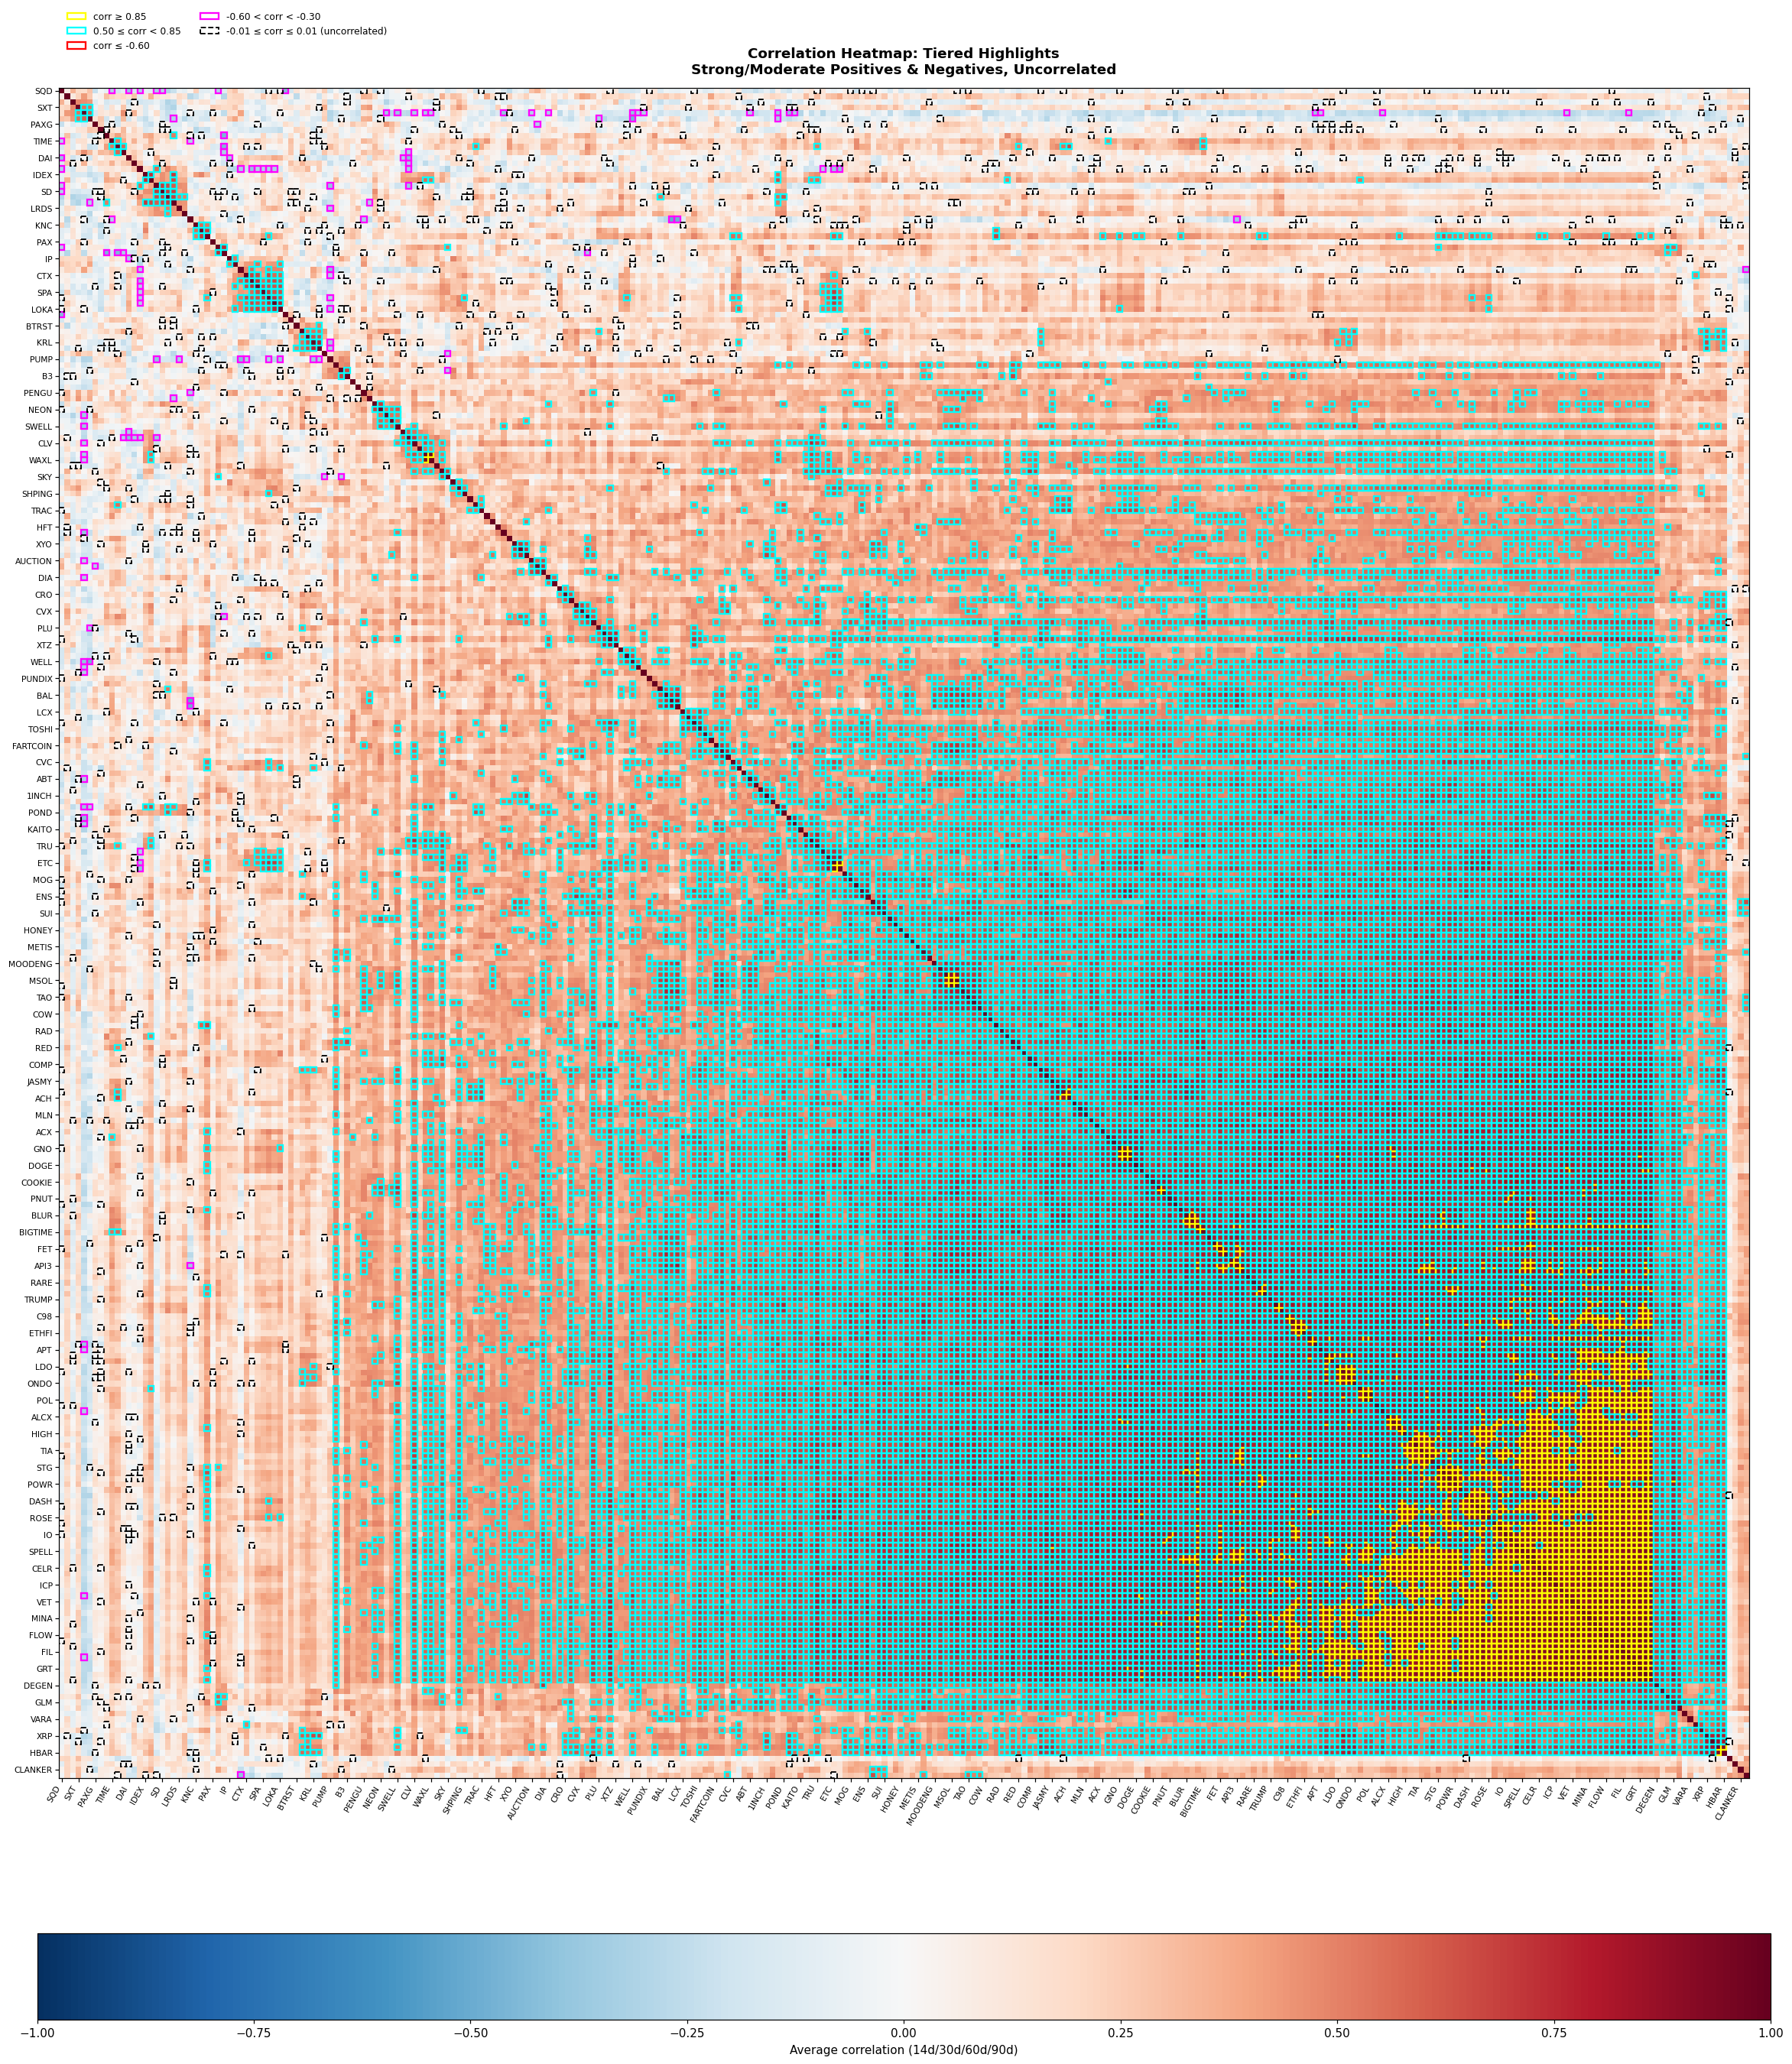

In [47]:
# --- Interactive Heatmap from Excel (strong +, strong -, near-zero), with robust fallbacks ---
import os
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

# =========================
# Knobs
# =========================
PROJECT_ROOT = r"C:\Users\User\PycharmProjects\LiveTradingBots"
CH3_DIR = os.path.join(PROJECT_ROOT, "Cryptocurrency Analysis Journal", "Chapter_3_MacroAnalysis_1d")
XLSX_PATH = os.path.join(CH3_DIR, "pairs_correlation_master.xlsx")

TOP_POS_PAIRS      = 800   # take this many strongest positive pairs from sheet
TOP_NEG_PAIRS      = 800   # take this many strongest negative pairs from sheet
TOP_NEUTRAL_PAIRS  = 800   # take this many closest-to-zero pairs from sheet
MAX_HEATMAP_SYMBOLS = 311  # final cap on symbol count for the heatmap
DO_CLUSTER          = True # hierarchical clustering for readability

# =========================
# 1) Load the three ranked tables from Excel
# =========================
sheets_needed = ["TopPositive", "TopNegative", "TopUncorrelated"]
xlsx = pd.read_excel(XLSX_PATH, sheet_name=sheets_needed)

def _ensure_cols(df, name):
    needed = {"sym_a","sym_b","corr_avg"}
    miss = needed - set(df.columns)
    if miss:
        raise KeyError(f"{name} is missing required columns: {miss}")

pos_df = xlsx["TopPositive"].copy()
neg_df = xlsx["TopNegative"].copy()
unc_df = xlsx["TopUncorrelated"].copy()
_ensure_cols(pos_df, "TopPositive")
_ensure_cols(neg_df, "TopNegative")
_ensure_cols(unc_df, "TopUncorrelated")

# Keep requested tops
pos_take = pos_df.head(TOP_POS_PAIRS)[["sym_a","sym_b","corr_avg"]].assign(bucket="pos")
neg_take = neg_df.head(TOP_NEG_PAIRS)[["sym_a","sym_b","corr_avg"]].assign(bucket="neg")
unc_take = unc_df.head(TOP_NEUTRAL_PAIRS)[["sym_a","sym_b","corr_avg"]].assign(bucket="neu")

# =========================
# 2) Build union of symbols; cap by absolute strength if needed
# =========================
sel_all = pd.concat([pos_take, neg_take, unc_take], ignore_index=True)

# strength for selection: absolute for pos/neg; distance-to-zero for neutral (which already sorted by |corr|)
strength = sel_all.copy()
strength["abs_strength"] = np.where(
    strength["bucket"].isin(["pos","neg"]),
    strength["corr_avg"].abs(),
    np.maximum(0, 1 - strength["corr_avg"].abs()) # neutral pairs get low abs corr; invert to give them priority too
)

# Union of symbols
union_syms = pd.unique(sel_all[["sym_a","sym_b"]].values.ravel("K"))
union_syms = [s for s in union_syms if isinstance(s, str)]

# If too many symbols, keep those appearing in the **strongest pairs first**
if len(union_syms) > MAX_HEATMAP_SYMBOLS:
    # rank pairs by priority: pos/neg by |corr| desc; neutral by |corr| asc (which we modeled above via abs_strength)
    # We'll turn abs_strength into a sort key: higher is more important.
    # For neutral, the transformation gave higher values to closer-to-zero pairs.
    strength_sorted = strength.sort_values("abs_strength", ascending=False).reset_index(drop=True)

    # Build a greedy selection of symbols until we hit MAX_HEATMAP_SYMBOLS
    keep_set = set()
    for _, r in strength_sorted.iterrows():
        if len(keep_set) >= MAX_HEATMAP_SYMBOLS:
            break
        keep_set.add(r["sym_a"])
        if len(keep_set) >= MAX_HEATMAP_SYMBOLS:
            break
        keep_set.add(r["sym_b"])
    present_syms = list(keep_set)
else:
    present_syms = union_syms

# =========================
# 3) Get averaged correlation matrix Cavg (from earlier cell or rebuild)
# =========================
def rebuild_Cavg_from_parquet():
    # Fallback: recompute Cavg from research parquet using pairwise complete obs
    parquet_path = r"C:\Users\User\PycharmProjects\LiveTradingBots\research_ohlcv_1d.parquet"
    df = pd.read_parquet(parquet_path)
    df["date"] = pd.to_datetime(df["date"], utc=False)
    df = df.sort_values(["symbol","date"])
    if "r1" not in df.columns:
        df["r1"] = df.groupby("symbol", group_keys=False)["close"].apply(
            lambda s: s.pct_change(fill_method=None)
        )
    ret = df.pivot(index="date", columns="symbol", values="r1").sort_index()

    horiz = {"14d":14,"30d":30,"60d":60,"90d":90}
    mats = []
    for w in horiz.values():
        tail = ret.dropna(how="all").tail(w)
        mats.append(tail.corr())

    # Align and average (NaN-safe mean)
    syms = sorted(set().union(*[set(m.columns) for m in mats]))
    mats = [m.reindex(index=syms, columns=syms) for m in mats]
    stack = np.stack([m.values for m in mats], axis=2)
    Cavg = pd.DataFrame(np.nanmean(stack, axis=2), index=syms, columns=syms)
    return Cavg

if "Cavg" not in globals():
    Cavg = rebuild_Cavg_from_parquet()

# Filter to symbols that actually exist in Cavg
present_syms = [s for s in present_syms if s in Cavg.index]
if len(present_syms) < 3:
    raise ValueError(f"Only {len(present_syms)} symbols intersect with Cavg. Increase TOP_* knobs or ensure Cavg covers these names.")

Csub = Cavg.reindex(index=present_syms, columns=present_syms)
Csub = Csub.dropna(axis=0, how="all").dropna(axis=1, how="all")

# =========================
# 4) Optional clustering for readability
# =========================
if DO_CLUSTER and Csub.shape[0] >= 3:
    d = np.sqrt(np.clip((1 - Csub.values)/2, 0, 1))
    if np.isnan(d).any():
        col_means = np.nanmean(d, axis=0)
        inds = np.where(np.isnan(d))
        d[inds] = np.take(col_means, inds[1])
    Z = linkage(squareform(d, checks=False), method="average")
    order = leaves_list(Z)
    Csub = Csub.iloc[order, order]

# === Matplotlib correlation heatmap (full matrix) with threshold highlights ===
# - Uses the full Csub (no symbol cap here)
# - Highlights cells with corr <= -0.50 (red outline) and >= +0.80 (gold outline)
# - Handles NaNs (shown as light gray)
# - Thins tick labels so the figure renders without clipping

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

# ---------- Required: Csub must exist (square DataFrame of avg correlations) ----------
if "Csub" not in globals():
    raise NameError("Csub not found. Build it first (averaged correlation matrix subset).")

Z = np.asarray(Csub.values, dtype=float)
rows = list(map(str, Csub.index.tolist()))
cols = list(map(str, Csub.columns.tolist()))
nrows, ncols = Z.shape

# ---------- Colormap with NaN color ----------
base = plt.cm.RdBu_r(np.linspace(0, 1, 256))
cmap = ListedColormap(base)
cmap.set_bad(color="#f0f0f0")  # light gray for missing

# Mask NaNs so they render in set_bad
Z_masked = np.ma.array(Z, mask=~np.isfinite(Z))

# ---------- Figure sizing & layout ----------
# Scale canvas by matrix size (with sane caps), thin tick labels to avoid clipping
CELL_W_IN = 0.20  # inches per column
CELL_H_IN = 0.20  # inches per row
MAX_W_IN  = 38.0  # hard cap
MAX_H_IN  = 30.0

fig_w = min(MAX_W_IN, max(10.0, CELL_W_IN * ncols))
fig_h = min(MAX_H_IN, max(8.0,  CELL_H_IN * nrows))

fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=110)

# ---------- Heatmap ----------
im = ax.imshow(Z_masked, cmap=cmap, vmin=-1, vmax=1, origin="upper", interpolation="nearest")

# Colorbar above to avoid right cutoff
cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.08, fraction=0.05, shrink=0.7)
cbar.set_label("Average correlation (14d/30d/60d/90d)")

# ---------- Tick labels (thinned) ----------
TARGET_TICKS = 80  # adjust if you want more/less labels shown
def _tick_every(total, target):
    return max(1, total // max(1, target))

x_step = _tick_every(ncols, TARGET_TICKS)
y_step = _tick_every(nrows, TARGET_TICKS)

ax.set_xticks(range(0, ncols, x_step))
ax.set_xticklabels([cols[i] for i in range(0, ncols, x_step)], rotation=60, ha="right", fontsize=7)
ax.set_yticks(range(0, nrows, y_step))
ax.set_yticklabels([rows[i] for i in range(0, nrows, y_step)], fontsize=7)

# Keep ticks inside axes bounds
ax.tick_params(axis='x', which='both', pad=2)
ax.tick_params(axis='y', which='both', pad=2)

# ---------- Gridlines (optional, very light for large matrices) ----------
ax.set_xlim(-0.5, ncols - 0.5)
ax.set_ylim(nrows - 0.5, -0.5)  # origin='upper' flips y; set explicit limits

# ---------- Threshold highlights (blatantly different colors) ----------
from matplotlib.patches import Rectangle

# Tiers
POS_STRONG = 0.85
POS_MODERATE = 0.50
NEG_STRONG = -0.60
NEG_MODERATE = -0.30
UNC_LOW, UNC_HIGH = -0.01, 0.01

finite = np.isfinite(Z)
diag_mask = (np.eye(nrows, ncols) == 1)

# Index sets
pos_strong_idx   = np.argwhere(finite & (Z >= POS_STRONG) & (~diag_mask))
pos_mod_idx      = np.argwhere(finite & (Z >= POS_MODERATE) & (Z < POS_STRONG) & (~diag_mask))
neg_strong_idx   = np.argwhere(finite & (Z <= NEG_STRONG))
neg_mod_idx      = np.argwhere(finite & (Z < NEG_MODERATE) & (Z > NEG_STRONG))
uncorrelated_idx = np.argwhere(finite & (Z >= UNC_LOW) & (Z <= UNC_HIGH) & (~diag_mask))

# High-contrast styles
STYLE = {
    "pos_strong":   dict(edgecolor="#ffff00", linewidth=1.5, linestyle="-"),  # bright yellow
    "pos_mod":      dict(edgecolor="#00ffff", linewidth=1.5, linestyle="-"),  # cyan
    "neg_strong":   dict(edgecolor="#ff0000", linewidth=1.5, linestyle="-"),  # red
    "neg_mod":      dict(edgecolor="#ff00ff", linewidth=1.5, linestyle="-"),  # magenta
    "uncorrelated": dict(edgecolor="#000000", linewidth=1.2, linestyle="--"), # black dashed
}

def _draw_boxes(indices, style):
    for (i, j) in indices:
        rect = Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, **style)
        ax.add_patch(rect)

_draw_boxes(pos_strong_idx,   STYLE["pos_strong"])
_draw_boxes(pos_mod_idx,      STYLE["pos_mod"])
_draw_boxes(neg_strong_idx,   STYLE["neg_strong"])
_draw_boxes(neg_mod_idx,      STYLE["neg_mod"])
_draw_boxes(uncorrelated_idx, STYLE["uncorrelated"])

# Legend proxies
proxies = [
    Rectangle((0,0), 1, 1, fill=False, **STYLE["pos_strong"]),
    Rectangle((0,0), 1, 1, fill=False, **STYLE["pos_mod"]),
    Rectangle((0,0), 1, 1, fill=False, **STYLE["neg_strong"]),
    Rectangle((0,0), 1, 1, fill=False, **STYLE["neg_mod"]),
    Rectangle((0,0), 1, 1, fill=False, **STYLE["uncorrelated"]),
]
labels = [
    f"corr ≥ {POS_STRONG:.2f}",
    f"{POS_MODERATE:.2f} ≤ corr < {POS_STRONG:.2f}",
    f"corr ≤ {NEG_STRONG:.2f}",
    f"{NEG_STRONG:.2f} < corr < {NEG_MODERATE:.2f}",
    f"{UNC_LOW:.2f} ≤ corr ≤ {UNC_HIGH:.2f} (uncorrelated)",
]

ax.legend(proxies, labels, loc="upper left", bbox_to_anchor=(0, 1.05),
          fontsize=8, ncol=2, frameon=False)

plt.title(
    "Correlation Heatmap: Tiered Highlights\nStrong/Moderate Positives & Negatives, Uncorrelated",
    fontsize=12,
    fontweight="bold",
    pad=12
)

plt.show()